In [2]:
%matplotlib inline

In [3]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# Modified for project porpuses by: Cristian Gonzalez-Colin
# License: BSD 3 clause
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA, FastICA, KernelPCA, TruncatedSVD, DictionaryLearning, FactorAnalysis, NMF
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, AllKNN, EditedNearestNeighbours, RepeatedEditedNearestNeighbours

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel


In [4]:
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      return {"Mean Training Accuracy": results['train_accuracy'].mean(),
              "Mean Training Precision": results['train_precision'].mean(),
              "Mean Training Recall": results['train_recall'].mean(),
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Mean Validation Accuracy": results['test_accuracy'].mean(),
              "Mean Validation Precision": results['test_precision'].mean(),
              "Mean Validation Recall": results['test_recall'].mean(),
              "Mean Validation F1 Score": results['test_f1'].mean()
              }
     #  return {"Training Accuracy scores": results['train_accuracy'],
     #          "Mean Training Accuracy": results['train_accuracy'].mean(),
     #          "Training Precision scores": results['train_precision'],
     #          "Mean Training Precision": results['train_precision'].mean(),
     #          "Training Recall scores": results['train_recall'],
     #          "Mean Training Recall": results['train_recall'].mean(),
     #          "Training F1 scores": results['train_f1'],
     #          "Mean Training F1 Score": results['train_f1'].mean(),
     #          "Validation Accuracy scores": results['test_accuracy'],
     #          "Mean Validation Accuracy": results['test_accuracy'].mean(),
     #          "Validation Precision scores": results['test_precision'],
     #          "Mean Validation Precision": results['test_precision'].mean(),
     #          "Validation Recall scores": results['test_recall'],
     #          "Mean Validation Recall": results['test_recall'].mean(),
     #          "Validation F1 scores": results['test_f1'],
     #          "Mean Validation F1 Score": results['test_f1'].mean()
     #          }

In [5]:
tpm_cancer = pd.read_table("data/inputfiles/GSE131512_cancerTPM.txt")
x = pd.read_table("data/pnas_patient_info.csv", sep=",")
y = pd.read_table("data/inputfiles/GSE131512_metaData.csv", sep=",", index_col=None)[0:96]
x.reset_index(drop=True, inplace= True)
y.reset_index(drop=True, inplace= True)
metadata = pd.concat([x, y], axis = 1)
metadata = metadata[metadata["recurStatus"].notna()]
metadata = metadata.replace({"recurStatus":  {"R":-1,"N":1}})
metadata = metadata.set_axis(metadata['Sample name'], axis='index')

genes = pd.read_table('DEgenes_recurrent.txt', header=None)[0].values
genes = list(genes)
# # ####
tpm_cancer = tpm_cancer.transpose()
tpm = tpm_cancer
tpm = pd.merge(tpm, metadata, left_index=True, right_index=True, how='outer')

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,pr_cat,her2_cat,chemo,datechemostart,datechemoend,daterecurrence,recurStatus,Sample name,Age,Gender
C1,7.071605,13.279391,0.000000,6.212355,34.038592,9.231355,32.811263,19.136966,12.631348,11.220057,...,0,0,AC/T,31/12/2008,08/04/2009,29/06/2009,-1,C1,34.44,Female
C2,60.610797,47.424080,0.000000,2.218590,35.828348,4.395669,22.498053,0.000000,5.413170,48.083612,...,0,0,AC/T,31/12/2008,08/04/2009,29/06/2009,-1,C2,43.35,Female
C3,58.255903,60.455497,23.040206,12.120963,55.926653,8.005046,13.657227,14.935300,16.430065,14.594347,...,0,0,AC/T,07/01/2009,20/05/2009,09/11/2010,-1,C3,43.85,Female
C4,29.917356,6.482332,8.646690,6.065120,10.494273,0.000000,23.064209,18.683413,9.865584,8.215603,...,0,0,AC/T,07/01/2009,20/05/2009,09/11/2010,-1,C4,41.42,Female
C5,24.500322,53.675826,20.456404,16.142519,14.482668,0.000000,59.112604,8.840272,55.432674,0.000000,...,1,0,AC/T,12/01/2009,27/04/2009,22/12/2010,-1,C5,42.12,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C92,0.000000,0.000000,179.178412,83.788404,3.020339,0.000000,8.850761,0.000000,2.129548,37.832300,...,1,0,TC,12/11/2008,14/01/2009,01/03/2025,1,C92,40.77,Female
C93,38.189128,5.976111,15.942897,18.172309,27.411791,13.847925,35.438448,0.000000,15.916524,27.771431,...,1,0,AC/T,24/10/2008,12/02/2009,01/03/2025,1,C93,43.44,Female
C94,15.608352,6.280734,0.000000,2.938248,1.694651,0.000000,22.346922,0.000000,19.117537,39.800507,...,1,0,AC/T,24/10/2008,12/02/2009,01/03/2025,1,C94,43.90,Female
C95,51.519267,241.863225,0.000000,14.547636,3.729079,9.607693,16.391467,15.933703,22.348699,55.467977,...,1,1,AC/T,13/10/2008,19/01/2009,01/03/2025,1,C95,39.45,Female


In [6]:
y = pd.read_table("data/inputfiles/GSE131512_metaData.csv", sep=",", index_col=None)
y.shape

(128, 3)

In [7]:
tpm['cancertype'] = tpm['cancertype'].factorize()[0]
tpm['Gender'] = tpm['Gender'].factorize()[0]
tpm['chemo'] = tpm['chemo'].factorize()[0]


In [20]:
def hyperparameter_tuner(name, clf):
    if name == "Nearest Neighbors":
        param_dist = {'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
    elif name == "Linear SVM":
        param_dist = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        }
    elif name == "RBF SVM":
        param_dist = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        }
    elif name == "Poly SVM":
        param_dist = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        }
    elif name == "Gaussian Process":
        param_dist = [{
            "kernel": [RBF(l) for l in np.logspace(-1, 1, 2)]
        }, {
            "kernel": [DotProduct(sigma_0) for sigma_0 in np.logspace(-1, 1, 2)]
        }, {
            "kernel": [1*Matern(z) for z in np.logspace(-1, 1, 2)]
        }, {
            "kernel": [1*RationalQuadratic(w) for w in np.logspace(-1, 1, 2)]
        }, {
            "kernel": [1*WhiteKernel(y)for y in np.logspace(-1, 1, 2)]
        }]
    elif name == "Decision Tree":
        param_dist = {'criterion': ['gini', 'log_loss', 'entropy'],
                      'max_features': ['auto', 'sqrt', None, 'log2']}
    elif name == "Random Forest":
        param_dist = {'criterion': ['gini', 'log_loss', 'entropy'],
                      'max_features': ['auto', 'sqrt', None, 'log2'],
                      'n_estimators': [10, 100, 500, 1000]}
    elif name == "Neural Net":
        param_dist = {'activation': ['relu', 'tanh', 'identtity', 'logistic'],
                      'solver': ['lbfgs', 'sgd', 'adam'],
                      'learning_rate': ['constant', 'invscaling', 'adaptive']}
                        # 'hidden_layers': [(5, 10, 5), (2, 5, 2), (5, 5), (10, 10)]}
    elif name == "AdaBoost":
        param_dist = {'algorithm':['SAMME', 'SAMME.R'],
                      "n_estimators": [10, 50, 100, 1000]}
    elif name == "Naive Bayes":
        param_dist = {}
    elif name == "QDA":
        param_dist = {}
    else:
        print(name, "not recognized...")

    rand_search = RandomizedSearchCV(clf, 
                                 param_distributions = param_dist, 
                                 n_iter=20, 
                                 cv=5)
    
    return(rand_search)

Nearest Neighbors
Linear SVM
RBF SVM
Poly SVM
Gaussian Process


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

Decision Tree


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  

Random Forest


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/joblib/parallel.py", line 1085, in __call__
  

Neural Net


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py", line 752, in fit
    return self._fit(X, y, incremental=False)
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/s

AdaBoost


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searc

Naive Bayes
QDA
Nearest Neighbors


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searc

Linear SVM
RBF SVM
Poly SVM
Gaussian Process


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_process/kernels

Decision Tree


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  

Random Forest


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/joblib/parallel.py", line 1085, in __call__
  

Neural Net


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py", line 752, in fit
    return self._fit(X, y, incremental=False)
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/s

AdaBoost


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searc

Naive Bayes
QDA
Nearest Neighbors


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searc

Linear SVM
RBF SVM
Poly SVM
Gaussian Process


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_proce

Decision Tree


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  

Random Forest


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/joblib/parallel.py", line 1085, in __call__
  

Neural Net


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarve

AdaBoost


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searc

Naive Bayes
QDA
Nearest Neighbors


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searc

Linear SVM
RBF SVM
Poly SVM
Gaussian Process


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_proce

Decision Tree


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  

Random Forest


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/joblib/parallel.py", line 1085, in __call__
  

Neural Net


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
2

AdaBoost


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searc

Naive Bayes
QDA
Nearest Neighbors


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searc

Linear SVM
RBF SVM
Poly SVM
Gaussian Process


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_proce

Decision Tree


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  

Random Forest


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/joblib/parallel.py", line 1085, in __call__
  

Neural Net


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py", line 752, in fit
    return self._fit(X, y, incremental=False)
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/s

AdaBoost


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searc

Naive Bayes
QDA
Nearest Neighbors


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searc

Linear SVM
RBF SVM
Poly SVM
Gaussian Process


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_proce

Decision Tree


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  

Random Forest


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/joblib/parallel.py", line 1085, in __call__
  

Neural Net


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarve

AdaBoost


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searc

Naive Bayes
QDA
Nearest Neighbors


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searc

Linear SVM
RBF SVM
Poly SVM
Gaussian Process


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/gaus

Decision Tree


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  

Random Forest


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/joblib/parallel.py", line 1085, in __call__
  

Neural Net


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py", line 752, in fit
    return self._fit(X, y, incremental=False)
  File "/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/s

AdaBoost


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searc

Naive Bayes


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searc

QDA


/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/echarvel/miniconda3/envs/phylo/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/hom

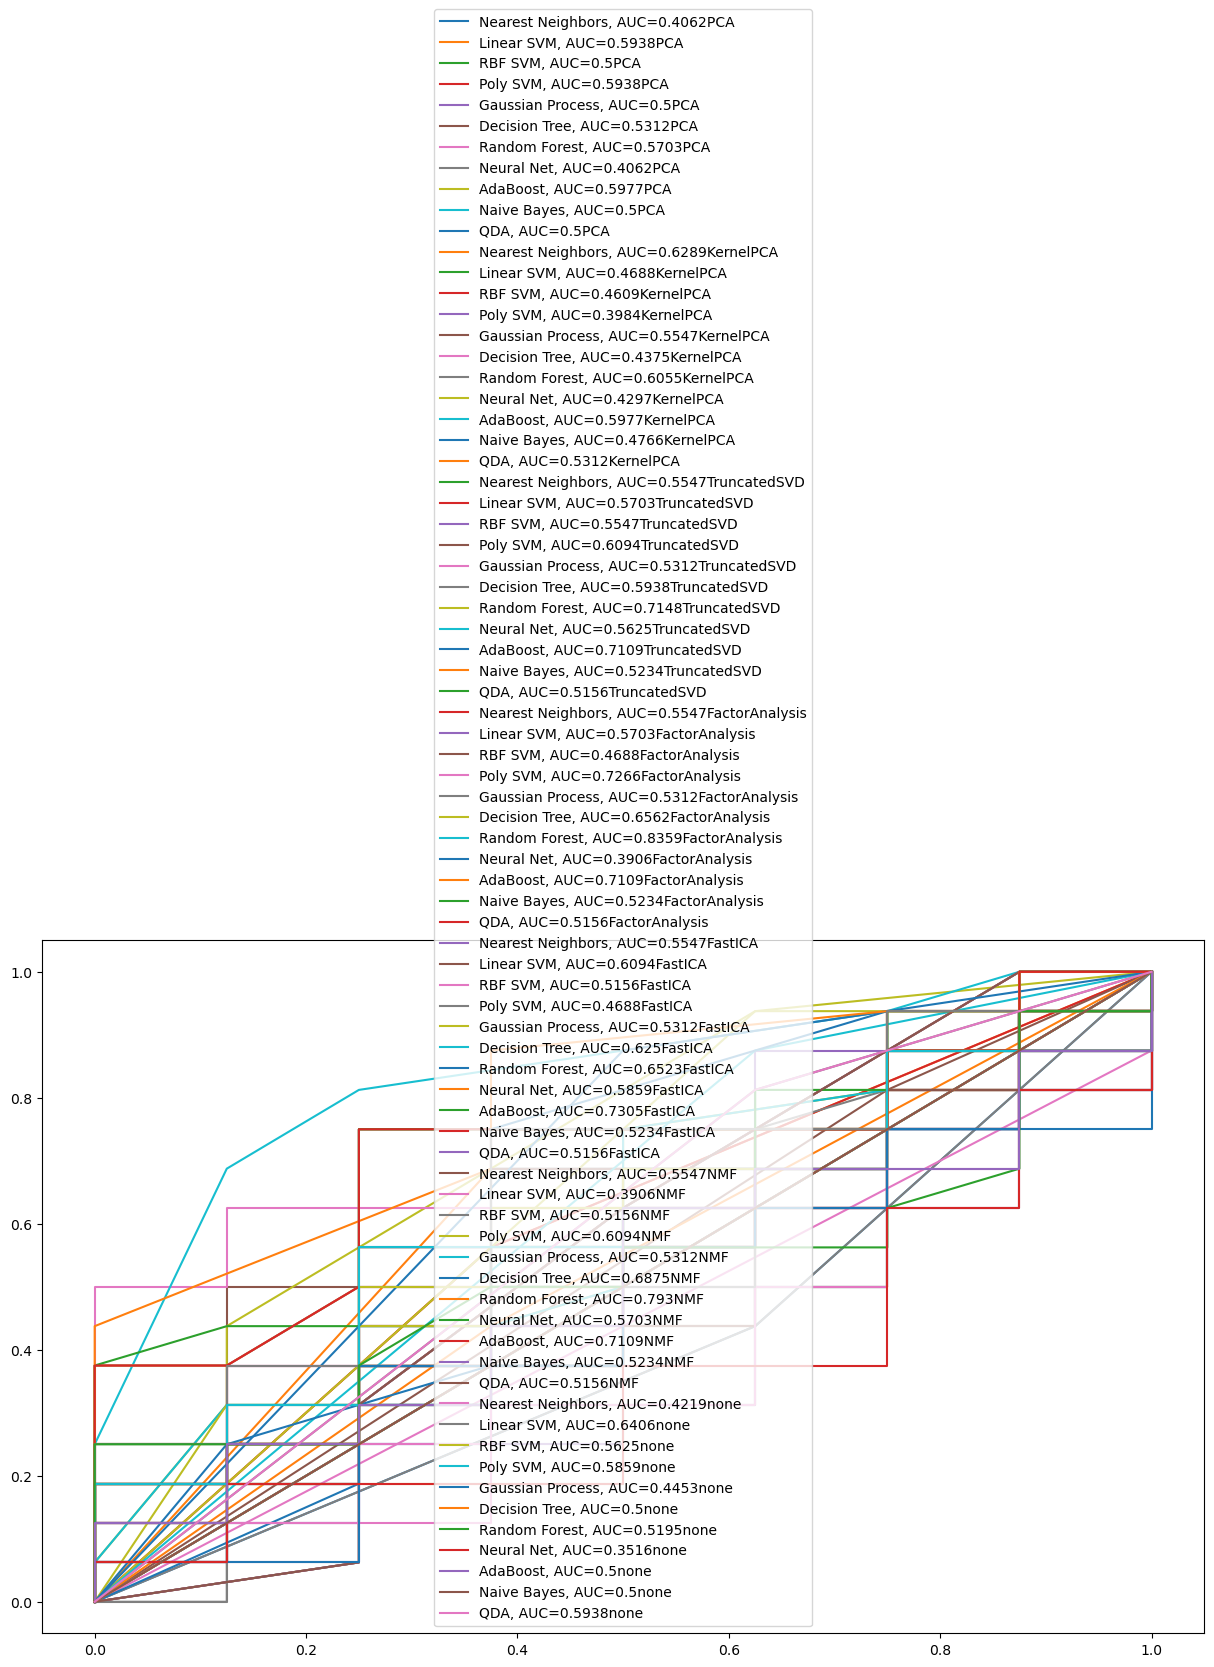

In [21]:

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Poly SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="linear",probability=True),
    SVC(gamma=2, C=1, probability=True),
    SVC(kernel="poly", probability=True),
    GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(max_iter=3000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

names_reduction = [
    "PCA",
    "KernelPCA",
    "TruncatedSVD",
    "FactorAnalysis",
    "FastICA",
    "NMF",
    "none"
]
    

features = genes
X = tpm[features ]#+ list(metadata.iloc[:,:-1].columns.values)]
y = metadata['recurStatus'].values

figure = plt.figure(figsize=(15, 9))
i = 1

# preprocess dataset, split into training and test part
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

##oversampling undersampling
# X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
# X_resampled, y_resampled = ADASYN().fit_resample(X_train, y_train)
# X_resampled, y_resampled = SVMSMOTE(random_state=42).fit_resample(X_train, y_train)
# X_resampled, y_resampled = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)

###undersampling
# X_resampled, y_resampled = RandomUnderSampler(random_state=0).fit_resample(X_train, y_train)
# X_resampled, y_resampled = AllKNN().fit_resample(X_train, y_train)
# X_resampled, y_resampled = EditedNearestNeighbours().fit_resample(X_train, y_train)
# X_resampled, y_resampled = RepeatedEditedNearestNeighbours().fit_resample(X_train, y_train)


# ##no resampling
# X_resampled = X_train
y_resampled = y_train
# save


i += 1
# iterate over classifiers
dataframes = []
for reduc in names_reduction:
    metrics = {}
    if reduc == "none":
        X_resampled = X_train
        X_test_tr = X_test
    else:
        # #### feature selection
        if reduc == "PCA":
            red = PCA().fit(X_train)
        elif reduc == "KernelPCA":
            red = KernelPCA().fit(X_train)
        elif reduc == "TruncatedSVD":
            red = TruncatedSVD().fit(X_train)
        elif reduc == "":
            red = FactorAnalysis().fit(X_train)
        elif reduc == "":
            red = NMF().fit(X_train)

        X_resampled = red.transform(X_train)
        X_test_tr = red.transform(X_test)

        red_name = reduc + ".pkl"
        joblib.dump(red, "results/reduction/" + red_name)

    for name, clf_n in zip(names, classifiers):

    # "Nearest Neighbors",
    # "Linear SVM",
    # "RBF SVM",
    # "Poly SVM",
    # "Gaussian Process",
    # "Decision Tree",
    # "Random Forest",
    # "Neural Net",
    # "AdaBoost",
    # "Naive Bayes",
    # "QDA",

        clf = hyperparameter_tuner(name, clf_n)

        print(name)
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_resampled, y_resampled)
        results = cross_validation(clf, X_resampled, y_resampled, 5)
        #score = clf.score(X_test, y_test)
        results['Dimensionality Reduction'] = reduc
        
        metrics[name] = results
        y_pred = clf.predict_proba(X_test_tr)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc = round(roc_auc_score(y_test, y_pred), 4)
        plt.plot(fpr,tpr,label=name + ", AUC="+str(auc) + reduc)
        model_name = name.replace(" ", "_") + "_" + reduc + ".pkl"
        joblib.dump(clf, "results/models/" + model_name) 

        plt.legend()

    df = pd.DataFrame.from_dict(metrics, orient='columns')
    df = df.transpose()
    dataframes.append(df)

metrics = pd.concat(dataframes)

In [23]:
metrics

,Mean Training Accuracy,Mean Training Precision,Mean Training Recall,Mean Training F1 Score,Mean Validation Accuracy,Mean Validation Precision,Mean Validation Recall,Mean Validation F1 Score,Dimensionality Reduction
Nearest Neighbors,0.777374,0.777374,1.0,0.870694,0.721905,0.721905,1.0,0.838462,PCA
Linear SVM,1.0,1.0,1.0,1.0,0.707619,0.724689,0.961818,0.825753,PCA
RBF SVM,0.993103,0.990909,1.0,0.995349,0.721905,0.729084,0.981818,0.835897,PCA
Poly SVM,0.889655,0.889655,1.0,0.936,0.721905,0.721905,1.0,0.838462,PCA
Gaussian Process,0.722202,0.722202,1.0,0.838694,0.721905,0.721905,1.0,0.838462,PCA
...,...,...,...,...,...,...,...,...,...
Random Forest,1.0,1.0,1.0,1.0,0.708571,0.718095,0.981818,0.829231,none
Neural Net,0.944828,0.944828,1.0,0.968,0.721905,0.738095,0.963636,0.833913,none
AdaBoost,1.0,1.0,1.0,1.0,0.64,0.710256,0.849091,0.772332,none
Naive Bayes,0.996552,1.0,0.995238,0.99759,0.707619,0.717509,0.98,0.828317,none


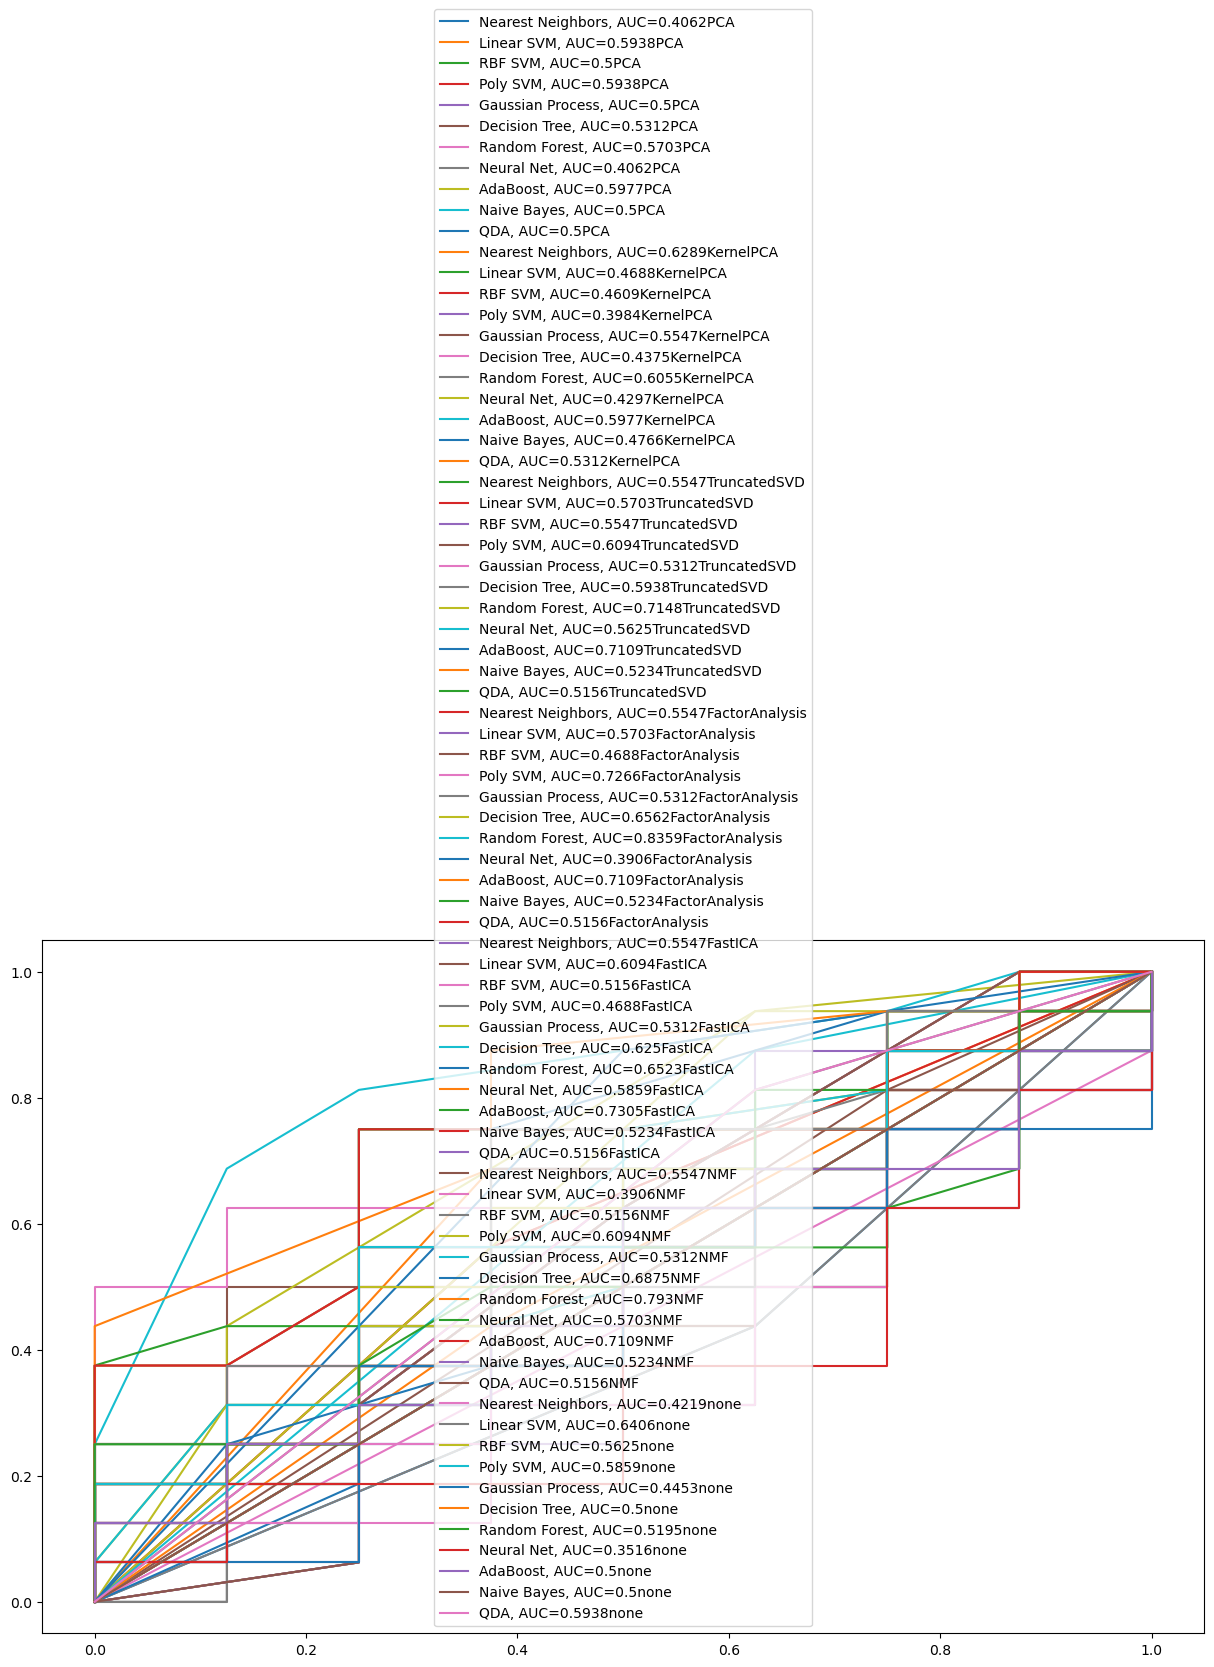

In [22]:
figure

In [24]:
metrics.to_csv("results/metrics_recurrentvvsnonrecurrent2.csv")